In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
import re

# Data ADDRESS

In [19]:
hostsNames = './data/WEBSPAM-UK2007-hostnames.txt'
hostLables = './data/WEBSPAM-UK2007-SET1-labels.txt'
graph = './data/uk-2007-05.hostgraph_weighted.graph-txt'

In [6]:
with open(hostsNames, 'r') as f_Names:
    ID2Name = {}
    for line in f_Names:
        line = line.strip().split()
        hostID, hostName = line
        ID2Name[hostID] = hostName

print(len(ID2Name))

114529


In [10]:
with open(hostLables, 'r') as f_Labels:
    ID2Label = {}
    for line in f_Labels:
        line = line.strip().split()[:2]
        hostID, hostLable = line
        ID2Label[hostID] = hostLable

print(len(ID2Label))

4275


In [44]:
with open(graph, 'r') as f_graph:
    edgeWeight = []
    for nodei, line in enumerate(f_graph):
        line = line.strip()
        if nodei == 0 or not line:
            continue
        else:     
            line = re.findall('[0-9]+:[0-9]+', line)
            for pair in line:
                nodej, weight = pair.split(':')
                # print(nodei-1, nodej, weight)
                edgeWeight.append((nodei - 1, nodej, weight))

print(len(edgeWeight),max(edgeWeight, key=lambda x: x[2]))

1836441 (1861, '1631', '99948')


In [11]:
print("Labeled data proportion: {0}, unlabeled data #: {1}".format(len(ID2Label)/len(ID2Name), len(ID2Name)-len(ID2Label)))

Labeled data proportion: 0.03732679059452191, unlabeled data #: 110254


In [18]:
SPAM, NONSPAM = {}, {}
for key, value in ID2Label.items():
    if value == 'spam':
        SPAM[key] = 1
    else:
        NONSPAM[key] = 0

print("# SPAM: {0}, # NONSPAM: {1}, PROPORTION: {2}".format(len(SPAM), len(NONSPAM), len(SPAM)/len(NONSPAM)))

# SPAM: 222, # NONSPAM: 4053, PROPORTION: 0.05477424130273871


# Construct graph

In [45]:
Graph = nx.Graph()

for edge in edgeWeight:
    nodei, nodej, weight = edge
    Graph.add_edge(nodei, int(nodej), weight=float(weight))  # it's fast

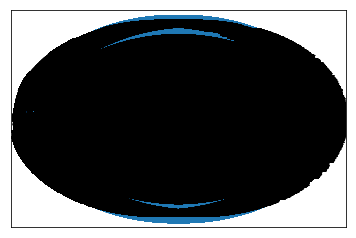

In [46]:
nx.draw_networkx(Graph, pos=nx.circular_layout(Graph), with_labels=True) # Need far more research on drawing

# ===================================================

# Graph Model

In [8]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [9]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

In [10]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(1433, 16, F.relu)
        self.gcn2 = GCN(16, 7, F.relu)

    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        return x
net = Net()
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=16, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


In [14]:
from dgl.data import citation_graph as citegrh
def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    train_mask = th.ByteTensor(data.train_mask)
    val_mask = th.ByteTensor(data.val_mask)
    test_mask = th.ByteTensor(data.test_mask)
    g = data.graph
    # add self loop
    g.remove_edges_from(g.selfloop_edges())
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, train_mask, val_mask, test_mask

In [13]:
def evaluate(logits, labels, mask):
    with torch.no_grad():
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [87]:
import time
import numpy as np
g, features, labels, train_mask, val_mask, test_mask = load_cora_data()
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(net.parameters(), lr=1e-3)
dur = []

for epoch in range(10):  # 150 epoch accuracy converge, loss still decrease
    if epoch >=3:
        t0 = time.time()

    logits = net(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        
    acc = evaluate(logits, labels, val_mask)
    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy {:.4f}".format(
            epoch, loss.item(), np.mean(dur), acc))

print('='*30)
acc = evaluate(logits, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

Epoch 00000 | Loss 0.6149 | Time(s) nan | Accuracy 0.6567
Epoch 00001 | Loss 0.6127 | Time(s) nan | Accuracy 0.6600
Epoch 00002 | Loss 0.6097 | Time(s) nan | Accuracy 0.6600
Epoch 00003 | Loss 0.6071 | Time(s) 0.4085 | Accuracy 0.6567
Epoch 00004 | Loss 0.6046 | Time(s) 0.4235 | Accuracy 0.6567
Epoch 00005 | Loss 0.6021 | Time(s) 0.4155 | Accuracy 0.6567
Epoch 00006 | Loss 0.5994 | Time(s) 0.4224 | Accuracy 0.6567
Epoch 00007 | Loss 0.5969 | Time(s) 0.4254 | Accuracy 0.6567
Epoch 00008 | Loss 0.5944 | Time(s) 0.4269 | Accuracy 0.6567
Epoch 00009 | Loss 0.5919 | Time(s) 0.4239 | Accuracy 0.6600
Test Accuracy 0.7180


# Try Graph Regularization

In [28]:
Graph.get_edge_data(0,1005)

NameError: name 'Graph' is not defined

In [38]:
import time
import numpy as np
import torch
g, features, labels, train_mask, val_mask, test_mask = load_cora_data()
loss_fcn = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(net.parameters(), lr=1e-3)
dur = []

for epoch in range(400):  #  epoch converge
    if epoch >=3:
        t0 = time.time()

    logits = net(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])
    for nodei, nodej in zip(g.edges()[0], g.edges()[1]):
        if train_mask[nodei] == 0 or train_mask[nodej] == 0:
            continue
        else:
            loss += sum((logits[nodei] - logits[nodej]) ** 2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        
    acc = evaluate(logits, labels, val_mask)
    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy {:.4f}".format(
            epoch, loss.item(), np.mean(dur), acc))

print('='*30)
acc = evaluate(logits, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

Epoch 00000 | Loss 0.6809 | Time(s) nan | Accuracy 0.7067
Epoch 00001 | Loss 1.1180 | Time(s) nan | Accuracy 0.7033
Epoch 00002 | Loss 1.6188 | Time(s) nan | Accuracy 0.7033
Epoch 00003 | Loss 0.9237 | Time(s) 0.5715 | Accuracy 0.7067
Epoch 00004 | Loss 0.8939 | Time(s) 0.5716 | Accuracy 0.7033
Epoch 00005 | Loss 1.1269 | Time(s) 0.5715 | Accuracy 0.7033
Epoch 00006 | Loss 0.9651 | Time(s) 0.5713 | Accuracy 0.7033
Epoch 00007 | Loss 0.7476 | Time(s) 0.5713 | Accuracy 0.7067
Epoch 00008 | Loss 0.8192 | Time(s) 0.5713 | Accuracy 0.7067
Epoch 00009 | Loss 0.9524 | Time(s) 0.5711 | Accuracy 0.7067
Epoch 00010 | Loss 0.8622 | Time(s) 0.5710 | Accuracy 0.7067
Epoch 00011 | Loss 0.7139 | Time(s) 0.5710 | Accuracy 0.7033
Epoch 00012 | Loss 0.7394 | Time(s) 0.5710 | Accuracy 0.7033
Epoch 00013 | Loss 0.8486 | Time(s) 0.5709 | Accuracy 0.7033
Epoch 00014 | Loss 0.8207 | Time(s) 0.5714 | Accuracy 0.7033
Epoch 00015 | Loss 0.7135 | Time(s) 0.5716 | Accuracy 0.7033
Epoch 00016 | Loss 0.7036 | Time(

Epoch 00135 | Loss 0.6698 | Time(s) 0.5729 | Accuracy 0.7033
Epoch 00136 | Loss 0.6697 | Time(s) 0.5728 | Accuracy 0.7033
Epoch 00137 | Loss 0.6696 | Time(s) 0.5728 | Accuracy 0.7033
Epoch 00138 | Loss 0.6695 | Time(s) 0.5727 | Accuracy 0.7033
Epoch 00139 | Loss 0.6694 | Time(s) 0.5727 | Accuracy 0.7033
Epoch 00140 | Loss 0.6694 | Time(s) 0.5726 | Accuracy 0.7033
Epoch 00141 | Loss 0.6693 | Time(s) 0.5726 | Accuracy 0.7033
Epoch 00142 | Loss 0.6692 | Time(s) 0.5725 | Accuracy 0.7033
Epoch 00143 | Loss 0.6691 | Time(s) 0.5725 | Accuracy 0.7033
Epoch 00144 | Loss 0.6690 | Time(s) 0.5724 | Accuracy 0.7033
Epoch 00145 | Loss 0.6689 | Time(s) 0.5724 | Accuracy 0.7033
Epoch 00146 | Loss 0.6688 | Time(s) 0.5723 | Accuracy 0.7033
Epoch 00147 | Loss 0.6688 | Time(s) 0.5722 | Accuracy 0.7033
Epoch 00148 | Loss 0.6687 | Time(s) 0.5722 | Accuracy 0.7033
Epoch 00149 | Loss 0.6686 | Time(s) 0.5721 | Accuracy 0.7033
Epoch 00150 | Loss 0.6685 | Time(s) 0.5721 | Accuracy 0.7033
Epoch 00151 | Loss 0.668

Epoch 00270 | Loss 0.6572 | Time(s) 0.5739 | Accuracy 0.7033
Epoch 00271 | Loss 0.6571 | Time(s) 0.5739 | Accuracy 0.7033
Epoch 00272 | Loss 0.6570 | Time(s) 0.5739 | Accuracy 0.7033
Epoch 00273 | Loss 0.6569 | Time(s) 0.5741 | Accuracy 0.7033
Epoch 00274 | Loss 0.6568 | Time(s) 0.5743 | Accuracy 0.7033
Epoch 00275 | Loss 0.6567 | Time(s) 0.5745 | Accuracy 0.7033
Epoch 00276 | Loss 0.6566 | Time(s) 0.5746 | Accuracy 0.7033
Epoch 00277 | Loss 0.6565 | Time(s) 0.5748 | Accuracy 0.7033
Epoch 00278 | Loss 0.6564 | Time(s) 0.5749 | Accuracy 0.7033
Epoch 00279 | Loss 0.6563 | Time(s) 0.5750 | Accuracy 0.7033
Epoch 00280 | Loss 0.6563 | Time(s) 0.5750 | Accuracy 0.7033
Epoch 00281 | Loss 0.6562 | Time(s) 0.5750 | Accuracy 0.7033
Epoch 00282 | Loss 0.6561 | Time(s) 0.5750 | Accuracy 0.7033
Epoch 00283 | Loss 0.6560 | Time(s) 0.5751 | Accuracy 0.7033
Epoch 00284 | Loss 0.6559 | Time(s) 0.5750 | Accuracy 0.7033
Epoch 00285 | Loss 0.6557 | Time(s) 0.5750 | Accuracy 0.7033
Epoch 00286 | Loss 0.655

In [25]:
np.sum((np.arange(9) - np.arange(5,14))**2)

225

In [26]:
torch.cuda.is_available()

False